In [27]:
import numpy as np; import matplotlib.pyplot as plt
import pymc3 as pm; from scipy import stats; 
import pandas as pd ;import os 
import theano; import seaborn as sns; 
from theano import shared, tensor as tt
# Age, Age Error, 40Ar, 39Ar, 37Ar, 36Ar, Temperature
cwd = os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df = pd.read_csv("mix_hb_tcr_acs.csv", engine = 'python')

# Sum of Squares 

In [28]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)


def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5

    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma

    return floatX(tau), floatX(sigma)


class Sum_of_Squares(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()

In [29]:
temp = df['Temperature (Degrees Celcius)'].values
age = df['Age'].values
age_err = df['Age Error'].values
ar39 = df['39Ar'].values

In [30]:
def frel(a): 
    y = np.cumsum(a)
    z = y/y.max()
    return z

In [31]:
ww = frel(ar39)

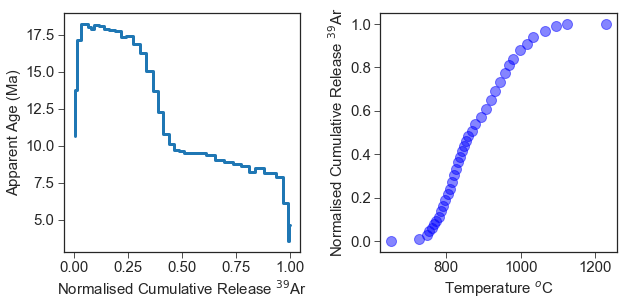

In [32]:
font = {"family": "Arial", 
       "weight": "normal", 
       "size": 15}

plt.rc("font", **font)

sns.set_style('ticks')
fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].plot(ww, age, 
        drawstyle = 'steps', 
          lw = 3)
ax[1].plot(temp, ww, 'or', 
          color = 'blue', alpha = .48, markersize = 10)


ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Normalised Cumulative Release $^{39}$Ar')


ax[1].set_ylabel('Normalised Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}$C')

plt.tight_layout()

In [33]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T



def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [34]:
ww = frel(ar39)
R = 8.314e-3
tk = temp + 273.15
time = 300*np.ones(len(tk))
a_err = shared(age_err/2)
N = age.shape[0]

In [35]:
W = pm.Model() 
data3 = ww
data1 = age
with W:   

    # Volume Fraction 
    phi = pm.Dirichlet('phi', a = np.array([1, 1, 1]), 
                      shape = 3) 
    
    phi_con = pm.Potential('phi_con',
                          tt.switch(phi.min() < 0.2, 
                                   -np.inf, 0))
    
    p1 = phi[0]
    p2 = phi[1] 
    p3 = phi[2]

 
    # Diffusion Kinetics 
    ea1 = pm.Normal('ea1', 
                    mu = 220,
                    sd = 9)
    
    ea2 = pm.Normal('ea2',
                    mu = 196,
                    sd = 16)
    
    ea3 = pm.Normal('ea3', 
                    mu = 220,
                    sd = 9)    
    
    lnd01 = pm.Normal('lnd01', mu = 8.4,
                      sd = 1)
    
    lnd02 = pm.Normal('lnd02', mu = -2.6,
                      sd = 1.9)   
    
    lnd03 = pm.Normal('lnd03', mu = 8.4,
                      sd = 1)
    
    d01 = pm.Deterministic('d01',np.exp(lnd01) * (0.02**2))
    
    d02 = pm.Deterministic('d02', np.exp(lnd02))
    
    d03 = pm.Deterministic('d03',np.exp(lnd03) * (0.02**2))
    
    # Effective Diffusive Lengthscale 
    a1 = pm.Uniform('a1', lower = 0.001, 
                           upper = 0.0032)
    
    a2 = pm.Uniform('a2', lower = 0.001, 
                           upper = 0.0032)
     
    a3 = pm.Uniform('a3',lower = 0.001, 
                           upper = 0.0032)

    


In [36]:
with W: 
    
    age1 = pm.Uniform('age1', lower = 0.0, upper = 4600, 
                 testval = 100)

    age2 = pm.Uniform('age2', lower = 0.0, upper = 4600, 
                     testval = 200)
    
    age3 = pm.Uniform('age3', lower = 0.0, upper = 4600, 
                     testval = 400)
    

    
    # Order Transform
    
    
    order_transform_1 = pm.Potential('order1', 
                                      tt.switch(age3 - age2 <0, 
                                               -np.inf, 0))
    
        
    order_transform_2= pm.Potential('order2', 
                                      tt.switch(age2 - age1 <0, 
                                               -np.inf, 0))
    

In [37]:
with W: 
    X = Increment(ea1, d01, a1, tk, time)
    Y = Increment(ea2, d02, a2, tk, time)
    Z = Increment(ea3, d03, a3, tk, time)

    w1 = p1
    w2 = p2
    w3 = p3
    
    mu2 = ((w1*X)/(w1*X + w2*Y + w3*Z))*age1 +\
    ((w2*Y)/(w1*X + w2*Y + w3*Z))*age2 +\
    ((w3*Z)/(w1*X + w2*Y + w3*Z))*age3

    
    YY = pm.Deterministic('YY', Y)
    XX = pm.Deterministic('XX', X)
    ZZ = pm.Deterministic('ZZ', Z)
    
    model2 = pm.Deterministic('model2', mu2)

In [38]:
with W:
    # Fractional Release 
    A = fracrelx(ea1, d01, a1, tk, time)
    B = fracrelx(ea2, d02, a2, tk, time)
    C = fracrelx(ea3, d03, a3, tk, time)
    
    mu1 = p1*A+ p2*B + p3*C

############################################################################
 # Add Monontonic Constraints to all fractional release 
    for i in range(len(tk) - 1): 
        fracrel_cons = pm.Potential(f'frel_cons_ind{i}', 
                                       tt.switch(A[i + 1] - A[i] < 0, 
                                                 -np.inf, 0) + 
                                       tt.switch(B[i + 1] - B[i] < 0, 
                                                -np.inf, 0)+ 
                                    tt.switch(C[i + 1] - C[i] < 0, 
                                             -np.inf, 0))  
    # Add Monontonic Constraints to all fractional release 
    for i in range(len(tk) - 1): 
        fracrel_cons = pm.Potential(f'frel_cons{i}', 
                                      tt.switch(mu1[i + 1] - mu1[i] < 0, 
                                                 -np.inf, 0))
        
    # Constraint to the fractional release model 
    frac_rel_cons = pm.Potential('frac_rel_cons_max', 
                                tt.switch(mu1 > 1,
                                          -np.inf,
                                          0))
############################################################################
    # Model 
    model1 = pm.Deterministic('model1', mu1)

    # Fractional Release Equation 
    f_err1 = pm.HalfNormal('f_err1', 
                           sd = 0.1, 
                          shape = N)

In [39]:
with W: 
    age_model_error = pm.HalfNormal('age_model_error', 
                                   sd = 2, shape = N)

In [40]:
with W: 
    #Fractional Release Likelihood
    
    obs1 = pm.Normal('obs1', mu = mu1, sd = f_err1, 
                    observed = data3)
    
    
    # Age Spectra Likelihood
    
    obs2 = Sum_of_Squares('obs2', mu2,
                             age_model_error,
                             observed = data1)
    

In [41]:
W.check_test_point()

a1_interval__             -1.39
a2_interval__             -1.39
a3_interval__             -1.39
age1                       1.89
age2                      -0.23
age3                      -0.23
age_model_error_log__    -30.03
ea1                       -3.12
ea2                       -3.69
ea3                       -3.12
f_err1_log__             -30.03
lnd01                     -0.92
lnd02                     -1.56
lnd03                     -0.92
obs1                       0.52
obs2                    -492.35
phi_stickbreaking__       -2.60
Name: Log-probability of test_point, dtype: float64

In [42]:
SEED = np.random.seed(123)
SAMPLES = 100000
BURN = 200000
with W: 
    
    step1 = pm.NUTS([phi], 
                   target_accept = 0.75)
    
    step2 = pm.Metropolis([ea1, ea2, 
                           d01, d02,
                           f_err1, 
                          age1, age2])
    
    
    step3 = pm.Metropolis([a1, a2, 
                          d01, d02])

    
    trace = pm.sample(SAMPLES, 
                      tune = BURN,  
                      step = pm.Metropolis(),  
                     random_seed = SEED,
                     cores = 3, 
                     chains = 3)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [age_model_error]
>Metropolis: [f_err1]
>Metropolis: [age3]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a3]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [lnd03]
>Metropolis: [lnd02]
>Metropolis: [lnd01]
>Metropolis: [ea3]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [phi]
Sampling 3 chains: 100%|██████████| 900000/900000 [1:18:33<00:00, 190.94draws/s] 
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


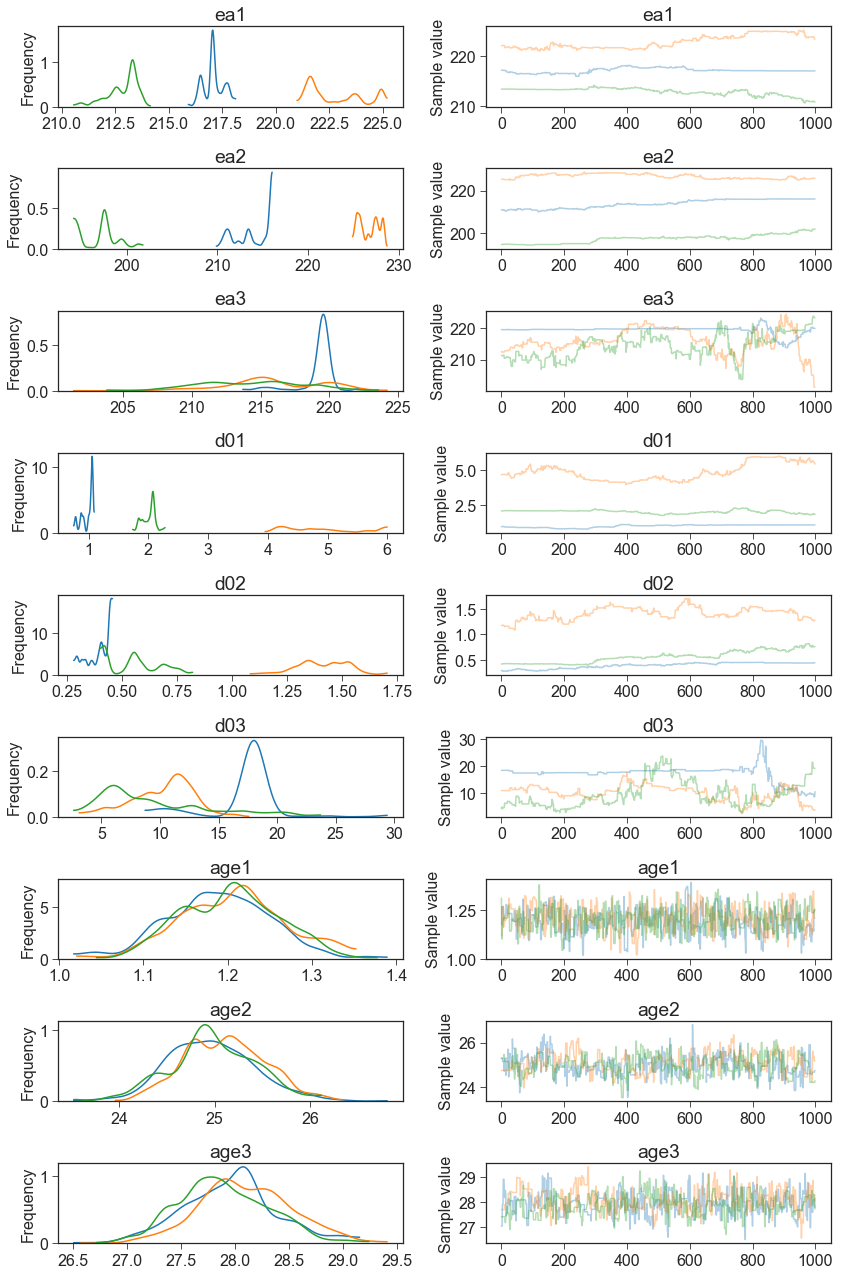

In [43]:
sns.set_style('ticks')
font = {"family": "Arial", 
      "size": 16, 
      "weight": "normal"}

plt.rc("font", **font)
pm.traceplot(trace[-1000:], 
            varnames = ['ea1', 'ea2', 'ea3',
                  'd01', 'd02', 'd03',
                  'age1', 'age2', 'age3']);  

In [44]:
with W: 
    ppc = pm.sample_ppc(trace[-10000:], 5000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 5000/5000 [00:42<00:00, 118.25it/s]


In [45]:
f_low, f_high = np.percentile(ppc['obs1'],
                              [2.5, 97.5],
                              axis = 0)

age_mod_low, age_mod_high = np.percentile(ppc['obs2'], 
                                         [2.5, 97.5], 
                                         axis = 0)

zz1 = ppc['obs1'].mean(axis = 0)
zz2 = ppc['obs2'].mean(axis = 0)

In [46]:
# Plotting Parameters
data2 = ww
data = age
age_low_plot = np.insert(age_mod_low, 0, age_mod_low[0])
age_high_plot = np.insert(age_mod_high, 0, age_mod_high[0])
f_mod_plot = np.insert(zz1, 0, 0)

model_plot = np.insert(zz2, 0, zz2[0])

data_err_plot = np.insert(age_err, 0, age_err[0])
data_plot = np.insert(age, 0, age[0])
f_plot = np.insert(data2, 0, 0)

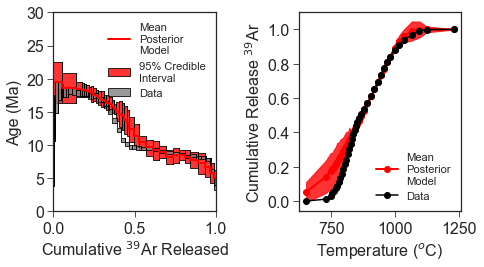

In [47]:
fig, ax = plt.subplots(1, 2, figsize = (7, 4))
ww = data2
ax[0].fill_between(f_mod_plot, age_low_plot, 
                  age_high_plot, 
                  step = 'pre',  
                  alpha = 0.8, 
                  facecolor = 'r', 
                  label = '95% Credible\nInterval', 
                  edgecolor = 'k')

ax[0].plot(f_mod_plot, model_plot, 'r-', 
          lw = 2, 
          label = 'Mean\nPosterior\nModel', 
          drawstyle = 'steps')


ax[0].fill_between(f_plot, data_plot + data_err_plot,
                   data_plot - data_err_plot, 
        step = 'pre', alpha = 0.8, facecolor = 'grey',
          edgecolor = 'k', 
                  label = 'Data')

for i in range(len(data)): 
    ax[0].vlines(f_mod_plot, age_low_plot, 
                  age_high_plot, color = 'k', lw= 0.7)

for i in range(len(data)): 
    ax[0].vlines(f_plot, data_plot + data_err_plot,
                   data_plot - data_err_plot,  color = 'k', lw= 0.7)

ax[1].fill_between(temp, f_low, f_high, 
                  color = 'r', alpha = 0.8)

ax[1].plot(temp, zz1, '-or', 
          lw = 2, label = 'Mean\nPosterior\nModel')
ax[1].plot(temp, ww, '-ok', 
          label = 'Data')

ax[0].set_ylim(0, 30)
ax[0].set_xlim(0, 1)


ax[0].set_xlabel('Cumulative $^{39}$Ar Released')
ax[0].set_ylabel('Age (Ma)')

ax[1].set_xlabel('Temperature ($^{o}$C)')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[0].legend(fontsize = 'x-small')
ax[1].legend(fontsize = 'x-small')
plt.tight_layout()
plt.savefig('hb_tcr_acs_age_frel.jpg')

In [48]:
print(trace['age1'].mean(axis = 0), 
      trace['age1'].std(axis = 0))
print(trace['age2'].mean(axis = 0), 
      trace['age2'].std(axis = 0))
print(trace['age3'].mean(axis = 0), 
      trace['age3'].std(axis = 0))

1.2018066856106284 0.06007411513045426
24.974719288519843 0.5002236205873426
27.9558783961282 0.48045722627376347


In [49]:
dfx = pm.trace_to_dataframe(trace[-SAMPLES::100])
df_pairgrid = pd.DataFrame({"age1":dfx['age1'].values, 
                   "age2": dfx['age2'].values, 
                   "age3" : dfx['age3'].values,
                   "ea1":dfx['ea1'].values, 
                   "ea2":dfx['ea2'].values, 
                   "ea3":dfx['ea3'].values,
                   "d01":dfx['d01'].values, 
                   "d02":dfx['d02'].values,
                   "d03":dfx['d03'].values})

In [1]:
import numpy as np; import matplotlib.pyplot as plt
import pymc3 as pm; from scipy import stats; import pandas as pd ;import os 
import theano; import seaborn as sns; from theano import shared, tensor as tt
import os 
cwd = os.chdir('/Users/jackcarter/Documents/Data_Mixtures')
dfhat = pd.read_csv('hb_acs_tcr_trace_a.csv')
dfx = dfhat
df_pairgrid = pd.DataFrame({"age1":dfx['age1'].values, 
                   "age2": dfx['age2'].values, 
                   "age3" : dfx['age3'].values,
                   "ea1":dfx['ea1'].values, 
                   "ea2":dfx['ea2'].values, 
                   "ea3":dfx['ea3'].values,
                   "d01":np.log(dfx['d01'].values), 
                   "d02":np.log(dfx['d02'].values),
                   "d03":np.log(dfx['d03'].values)})

Couldn't import dot_parser, loading of dot files will not be possible.


/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


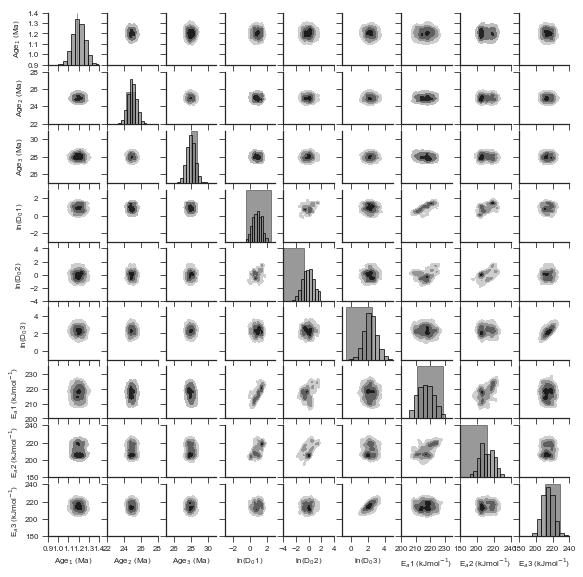

In [2]:
import seaborn as sns
sns.set_style('ticks')
font = {"family":"Arial", 
       "weight": "normal",
     "size": 8}


plt.rc("font", **font)

g = sns.PairGrid(df_pairgrid)
g = g.map_diag(plt.hist, facecolor = 'grey', edgecolor = 'k', 
              alpha = 0.7)
g.fig.set_size_inches(7.5,7.5)
g = g.map_offdiag(sns.kdeplot, cmap = 'Greys', 
                 n_levels = 4,
                 shade = True,
                 shade_lowest = False)



# Y_AXIS LABELS

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('Age$_3$ (Ma)')
g.axes[6,0].set_ylabel('E$_a$1 (kJmol$^{-1}$)')
g.axes[7,0].set_ylabel('E$_a$2 (kJmol$^{-1}$)')
g.axes[8,0].set_ylabel('E$_a$3 (kJmol$^{-1}$)')
g.axes[3,0].set_ylabel('ln(D$_0$1)')
g.axes[4,0].set_ylabel('ln(D$_0$2)')
g.axes[5,0].set_ylabel('ln(D$_0$3)');


# X_AXIS LABELS

g.axes[8,0].set_xlabel('Age$_1$ (Ma)')
g.axes[8,1].set_xlabel('Age$_2$ (Ma)')
g.axes[8,2].set_xlabel('Age$_3$ (Ma)')
g.axes[8,6].set_xlabel('E$_a$1 (kJmol$^{-1}$)')
g.axes[8,7].set_xlabel('E$_a$2 (kJmol$^{-1}$)')
g.axes[8,8].set_xlabel('E$_a$3 (kJmol$^{-1}$)')
g.axes[8,3].set_xlabel('ln(D$_0$1)')
g.axes[8,4].set_xlabel('ln(D$_0$2)')
g.axes[8,5].set_xlabel('ln(D$_0$3)');



# Axis limits
 
g.axes[0,0].set_ylim(0.9, 1.4)
g.axes[0,0].locator_params(axis = 'y', nbins = 5)
g.axes[8,0].set_xlim(0.9, 1.4)
g.axes[8,0].locator_params(axis = 'x', nbins = 5)


g.axes[1,0].set_ylim(22,28)
g.axes[1,0].locator_params(axis = 'y', nbins = 5)
g.axes[8,1].set_xlim(22,28)
g.axes[8,1].locator_params(axis = 'x', nbins = 5)



g.axes[2,0].set_ylim(25,31)
g.axes[2,0].locator_params(axis = 'y', nbins = 5)
g.axes[8,2].set_xlim(25,31)
g.axes[8,2].locator_params(axis = 'x', nbins = 5)


g.axes[3,0].set_ylim(-3,3)
g.axes[3,0].locator_params(axis = 'y', nbins = 5)
g.axes[8,3].set_xlim(-3,3)
g.axes[8,3].locator_params(axis = 'x', nbins = 5)



g.axes[4,0].set_ylim(-4,4)
g.axes[4,0].locator_params(axis = 'y', nbins = 5)
g.axes[8,4].set_xlim(-4,4)
g.axes[8,4].locator_params(axis = 'x', nbins = 5)


g.axes[5,0].set_ylim(-1,5)
g.axes[5,0].locator_params(axis = 'y', nbins = 5)
g.axes[8,5].set_xlim(-1,5)
g.axes[8,5].locator_params(axis = 'x', nbins = 5)


g.axes[6,0].set_ylim(200,235)
g.axes[6,0].locator_params(axis = 'y', nbins = 5)
g.axes[8,6].set_xlim(200,235)
g.axes[8,6].locator_params(axis = 'x', nbins = 5)


g.axes[7,0].set_ylim(180,240)
g.axes[7,0].locator_params(axis = 'y', nbins = 5)
g.axes[8,7].set_xlim(180,240)
g.axes[8,7].locator_params(axis = 'x', nbins = 5)


g.axes[8,0].set_ylim(180,240)
g.axes[8,0].locator_params(axis = 'y', nbins = 5)
g.axes[8,8].set_xlim(180,240)
g.axes[8,8].locator_params(axis = 'x', nbins = 5)



# Set 2 sigma limits

g.axes[1,1].axvspan(24.3,25.3, color = 'k',
                    ymax = 0.6, 
              alpha = 0.4)
g.axes[0,0].axvspan(1.18482,1.1852, 
                    color = 'k', ymax = 1, 
              alpha = 0.4)
g.axes[2,2].axvspan(28.01, 28.66, 
                    color = 'k', ymax = 1, 
              alpha = 0.4)

g.axes[3,3].axvspan(-0.5,2.5, 
                    color = 'k', ymax = 1, 
              alpha = 0.4)

g.axes[4,4].axvspan(-4.5, -0.7, 
                    color = 'k', ymax = 1, 
              alpha = 0.4)

g.axes[5,5].axvspan(-0.5,2.5, 
                    color = 'k', ymax = 1, 
              alpha = 0.4)


g.axes[6,6].axvspan(211,229, 
                    color = 'k', ymax = 1, 
              alpha = 0.4)


g.axes[7,7].axvspan(180,212, 
                    color = 'k', ymax = 1, 
              alpha = 0.4)



g.axes[8,8].axvspan(211,229, 
                    color = 'k', ymax = 1, 
              alpha = 0.4)


plt.savefig('hb_tcr_acs_pg1.jpg')

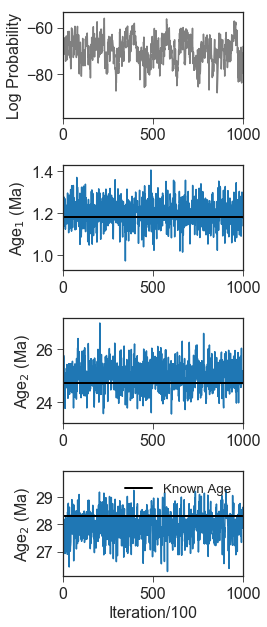

In [53]:
logp_model = W.logp
# Every Hundreth accepted sample
logp = [logp_model(i) for i in trace[-SAMPLES::10]]
# Trace Plotting
trace_plot = trace[-SAMPLES::70]

fig, ax = plt.subplots(4,1, figsize = (4, 9))

#Axis 1
ax[0].plot(logp, color = 'grey')
ax[0].set_ylabel('Log Probability')


# Axis 2
ax[1].plot(trace_plot['age1'])
ax[1].set_ylabel('Age$_{1}$ (Ma)')
ax[1].axhline(1.18, lw = 2, color = 'k', 
             label = 'Known Age')



# Axis 3
ax[2].plot(trace_plot['age2'])
ax[2].set_ylabel('Age$_{2}$ (Ma)')
ax[2].axhline(24.7, lw = 2, color = 'k', 
             label = 'Known Age')


# Axis 4
ax[3].plot(trace_plot['age3'])
ax[3].set_ylabel('Age$_{2}$ (Ma)')
ax[3].axhline(28.3, lw = 2, color = 'k', 
             label = 'Known Age')


plt.legend(fontsize = 'small')

ax[3].set_xlabel('Iteration/100')

ax[0].set_xlim(0,1000)
ax[1].set_xlim(0,1000)
ax[2].set_xlim(0,1000)
ax[3].set_xlim(0,1000)

plt.tight_layout()
plt.savefig('log_p_figure_hb_tcr_acs.jpg')

In [366]:
# Posterior Plotting Variables
df_age = pd.DataFrame({"age_m": model_plot, 
                    "age_low": age_low_plot, 
                    "age_high": age_high_plot,
                    "frel_plot": f_mod_plot, 
                    "data": data_plot,
                    "data_err": data_err_plot, 
                    "f_data_plot": f_plot})

df_frel = pd.DataFrame({"f_model": zz1,
                    "f_data": data2, 
                     "temp" : temp, 
                       "f_low": f_low, 
                       "f_high":f_high})

df_frel.to_csv("/Users/jackcarter/Documents/Data_Mixtures/hb_tcr_acs_frel_plot.csv")


df_age.to_csv("hb_tcr_acs_age_plot.csv")

In [67]:
dft = pm.trace_to_dataframe(trace[-SAMPLES::100])
dft.to_csv('hb_acs_tcr_trace_a.csv')